Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Model compiled!
Train on 264 samples, validate on 50 samples
Epoch 1/8
264/264 [==============================] - 0s 1ms/step - loss: 2.1727 - acc: 0.3409 - val_loss: 2.1714 - val_acc: 0.0000e+00
Epoch 2/8
264/264 [==============================] - 0s 105us/step - loss: 2.1298 - acc: 0.3598 - val_loss: 2.1512 - val_acc: 0.0000e+00
Epoch 3/8
264/264 [==============================] - 0s 102us/step - loss: 2.0843 - acc: 0.3598 - val_loss: 2.1322 - val_acc: 0.0000e+00
Epoch 4/8
264/264 [==============================] - 0s 103us/step - loss: 2.0330 - acc: 0.3598 - val_loss: 2.1150 - val_acc: 0.0000e+00
Epoch 5/8
264/264 [==============================] - 0s 110us/step - loss: 1.9771 - acc: 0.3598 - val_loss: 2.0977 - val_acc: 0.0000e+00
Epoch 6/8
264/264 [==============================] - 0s 91us/step - loss: 1.9185 - acc: 0.3598 - val_loss: 2.0877 - val_acc: 

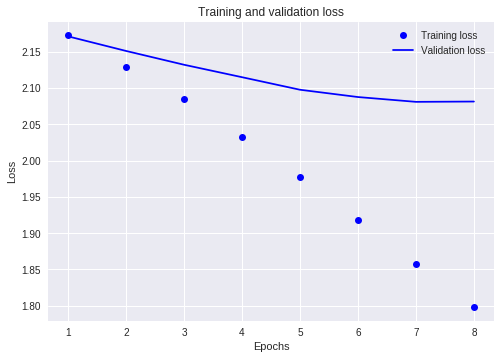

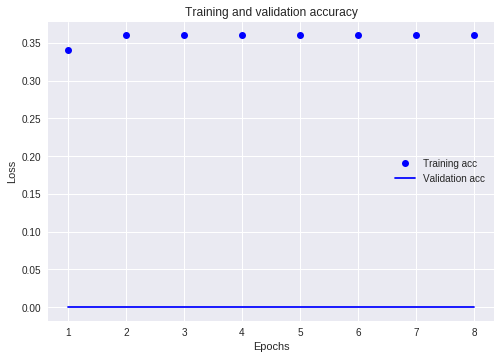

In [20]:
import os
import pandas as pd
import numpy as np
from keras import models
from keras import layers
from keras.utils import to_categorical

def mount_google_drive():
  from google.colab import drive
  drive.mount('/content/drive/')

def get_data_dir():
  if os.path.isdir('../input'):
    return '../input'
  else:
    mount_google_drive()
    if os.path.isdir(
      '/content/drive/My Drive/Colab Notebooks/lukier/whr/input'):
      global test_enabled
      test_enabled = False
      return '/content/drive/My Drive/Colab Notebooks/lukier/whr/input'
    else:
      raise FileNotFoundError
      
data_dir = get_data_dir()

def get_data():
  redundant_columns_2015 = ['Happiness Rank', 'Standard Error']
  x_train_df = pd.read_csv(data_dir + "/2015.csv").drop(redundant_columns_2015, 1)
  y_train = x_train_df['Happiness Score'].values
  x_train_df.drop('Happiness Score', 1, inplace=True)
  x_train_df.drop('Country', 1, inplace=True)
  x_train = x_train_df.values

  redundant_columns_2016 = ['Lower Confidence Interval', 'Upper Confidence Interval', 'Happiness Rank']
  x_train_df = pd.read_csv(data_dir + "/2016.csv").drop(redundant_columns_2016,1)
  y_train = np.append(y_train[:-1], x_train_df['Happiness Score'].values)
  x_train_df.drop('Happiness Score', 1, inplace=True)
  x_train_df.drop('Country', 1, inplace=True)
  x_train = np.vstack((x_train[:-1], x_train_df.values))
  return (x_train, y_train)

def prepare_model():
  model = models.Sequential()
  model.add(layers.Dense(16, activation='relu', input_shape=(8,)))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(9, activation='softmax'))
  model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  print('Model compiled!')
  return model

def prepare_input_x(x_train):
  regions = {}
  counter = 0
  for x in x_train:
    region = regions.get(x[0])
    if region == None:
      regions.update({x[0]: counter})
      counter += 1
      region = regions.get(x[0])
    x[0] = region
  for x in x_train:
    x[0] /= counter

  mean = x_train.mean(axis=0)
  x_train -= mean
#   TO-DO 
#   std = x_train.std(axis=0)
#   x_train /= std
  return x_train.astype('float32') / 255

def prepare_input_y(input_y):
  return to_categorical(input_y.round(0))
  
x_train, y_train = get_data()
x_train = prepare_input_x(x_train)
y_train = prepare_input_y(y_train)
x_val = x_train[:50]
partial_x_train = x_train[50:]
y_val = y_train[:50]
partial_y_train = y_train[50:]
model=prepare_model()

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=8,
                    batch_size=16,
                    validation_data=(x_val, y_val))


import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
